### The goal of this model is to predict the price of airline tickets for flights leaving O'Hare and Midway. 

**My model:**
I decided to focus on creating a model that works for round-trip fares only. As someone who flies a lot, I can hypothesize based on anecdote that one-way fares are generally much higher than round-trip fares and may have quite different parameters for prediction.

To determine if my anecdotal knowledge might be relevant, I investigated the summary statistics for a subset of the data based on whether the tickets were round-trip or one-way. It was easy to tell that these were very different sets of data. Among many examples I could pull from investigating those differences (see my related Python notebook "project3_data"), if we compare the means of each subset, the round-trip ticket mean is $426.55 (or $213.28 per half aka one-way ticket) and the one-way ticket mean is $309.44.

Although it might be possible to create a model that works well simultaneously for both round-trip and one-way tickets, that seems beyond my skills at the moment. This may be the case where the first step when predicting airline ticket prices is to choose one of two predictor models (and from my previous experience using real-world fare predictors out there, this is exactly what they do).

**Data issues:**
Some of the columns of data were clearly unnecessary or irrelevant to use for purposes of modeling: "OriginState" (everything is IL), "MilesFlown" and "DistanceGroup" (they are almost exactly the same as "Distance"), "BulkFare" (everything is zero). (See my "project3_data" document for the details on this.) Other columns were unclear. For example, the ItinFare values are already calculated per person, but does the number of tickets purchased at a time affect the price? Also the "Passengers" column had some weird outliers that probably should be dropped from the dataset, but I didn't do that due to time constraints.

**Models:**
So I went ahead and made a model (model_1) just using the straightforward columns that were already number-based, "Coupons", "OnLine", "Passengers", "Distance", "DistanceGroup". Obviously the airport from which someone flew (ORD or MDW) might be relevant, but that requires some more work and the airline flown definitely is relevant, so that work needs to be done. I started to think about waht model_2 would be. This would bring the airport and airline into the equation. 

In [1]:
% matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import datasets
from sklearn.linear_model import LinearRegression, Ridge

file_path = "airline_10.csv"

df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,ItinID,FarePerMile,Coupons,Origin,RoundTrip,OnLine,RPCarrier,Passengers,ItinFare,BulkFare,Distance,DistanceGroup,MilesFlown,OriginState
0,2936583,20161720654,0.2427,2,ORD,1.0,1.0,AA,1.0,896.0,0.0,3692.0,8,3692.0,IL
1,60732,201612861996,0.2103,2,ORD,1.0,1.0,OO,3.0,426.0,0.0,2026.0,5,2026.0,IL
2,1735933,201612425797,0.2565,2,ORD,1.0,0.0,G7,2.0,534.0,0.0,2082.0,5,2082.0,IL
3,1603577,201614110419,0.2793,2,MDW,1.0,1.0,WN,2.0,405.0,0.0,1450.0,3,1450.0,IL
4,2735471,201612424214,0.2054,2,ORD,1.0,1.0,G7,1.0,355.0,0.0,1728.0,4,1728.0,IL


In [7]:
#add any new columns that will be needed
#note: I ran short on time to do the dummies columns for airport and airline
#or that would be here too

#adds a column with distance squared
df["DistanceSqd"] = df["Distance"].apply(lambda x: x ** 2)

#AF note to self: when I tried to do this on just the subset, 
#it didn't work, so I did it before making the rt subset

#first create a dataframe with just the rt rows:
df_rt = df.loc[(df["RoundTrip"] == 1.0)]

#then create a target column from it to make typing easier:
target = df_rt["ItinFare"]

#then drop any unneeded columns and make a new dataframe with it that will be used for X

X = df_rt.drop(["Unnamed: 0", "ItinID", "FarePerMile", "ItinFare", "BulkFare", "MilesFlown", "OriginState", "DistanceGroup"], axis=1)

#and make one that doesn't have the string columns and also drops Distance in favor of DistanceSqd
X_2 = X.drop(["Origin", "RPCarrier", "Distance"], axis=1)

#AF note to self: I could make any needed X datasets here 
#so I don't have to specify columns below

print(X.head())
print(X_2.head())


   Coupons Origin  RoundTrip  OnLine RPCarrier  Passengers  Distance  \
0        2    ORD        1.0     1.0        AA         1.0    3692.0   
1        2    ORD        1.0     1.0        OO         3.0    2026.0   
2        2    ORD        1.0     0.0        G7         2.0    2082.0   
3        2    MDW        1.0     1.0        WN         2.0    1450.0   
4        2    ORD        1.0     1.0        G7         1.0    1728.0   

   DistanceSqd  
0   13630864.0  
1    4104676.0  
2    4334724.0  
3    2102500.0  
4    2985984.0  
   Coupons  RoundTrip  OnLine  Passengers  DistanceSqd
0        2        1.0     1.0         1.0   13630864.0
1        2        1.0     1.0         3.0    4104676.0
2        2        1.0     0.0         2.0    4334724.0
3        2        1.0     1.0         2.0    2102500.0
4        2        1.0     1.0         1.0    2985984.0


In [8]:
X_2.head()

,Coupons,RoundTrip,OnLine,Passengers,DistanceSqd
0,2,1.0,1.0,1.0,13630864.0
1,2,1.0,1.0,3.0,4104676.0
2,2,1.0,0.0,2.0,4334724.0
3,2,1.0,1.0,2.0,2102500.0
4,2,1.0,1.0,1.0,2985984.0


And in this cell below I was playing around with various combinations of different columns in x to see what happened with a straight up linear regression model, based on the columns that seemed promising from my data exploration in the project3_data notebook.

0.103906328258


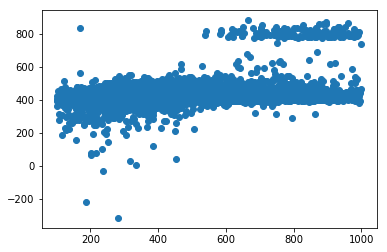

In [9]:
#my y is "ItinFare"
#using just the rt fares with the columns that just have numerical values
#and DistanceSqd instead of Distance
x = X_2.values 
y = target.values

model_1_lr = LinearRegression()
model_1_lr.fit(x, y)
     
predictions = model_1_lr.predict(x)

plt.scatter(y, predictions) #compares y to predicted y

print(model_1_lr.score(x,y))

Obviously the above isn't a particularly good model. So let's try it with Ridge...(I kept trying different alphas here)

0.10390632579


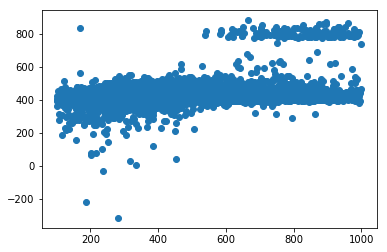

In [17]:
x = X_2.values 
y = target.values

model_1_ridge = Ridge(alpha=3)
model_1_ridge.fit(x, y)
     
predictions_2 = model_1_ridge.predict(x)

plt.scatter(y, predictions_2)
print(model_1_ridge.score(x,y))

Okay, still totally terrible and changing the alpha doesn't make much difference, so obviously just focusing on the columns that had numerical values to begin with was a bad idea.

In [6]:
#here, if I time had not run short, I would have tried another model
#with dummy variable columns for airlines and airport

In [18]:
#to finish up let's try some crossvalidation
from sklearn.model_selection import cross_val_score

In [20]:
cross_val_score(model_1_lr, X_2, target)

array([ 0.11324968,  0.10256227,  0.08998271])

In [21]:
cross_val_score(model_1_ridge, X_2, target)

array([ 0.1132469 ,  0.10256811,  0.08998345])

In [22]:
#well, at least everything is pretty much equally bad :)